In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack
from numpy import std
from numpy import mean

from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import average_precision_score, roc_curve, classification_report, precision_recall_curve


from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter('ignore')

In [7]:
df = pd.read_csv('FeaturesDF.csv')
df

,Unnamed: 0,entity_pair_names,Structural_similarity,Jaccardian_Similarity,Sequence_Similarity,Transformers_similarity,Spacy_similarity,Alignment
0,0,MA_0001263 / NCI_C33352,0.305460,0.533333,0.315789,0.227243,0.383,0
1,1,MA_0001263 / NCI_C33709,0.224362,0.133333,0.160000,0.273064,0.237,0
2,2,MA_0001263 / NCI_C33051,0.251242,0.153846,0.210526,0.066789,0.237,0
3,3,MA_0001263 / NCI_C25439,0.310933,0.400000,0.222222,0.283161,0.155,0
4,4,MA_0001263 / NCI_C38518,0.327367,0.470588,0.324324,0.176458,0.191,0
...,...,...,...,...,...,...,...,...
249995,249995,MA_0000482 / NCI_C32222,0.334022,0.437500,0.413793,0.217082,NaN,0
249996,249996,MA_0000482 / NCI_C12261,0.308390,0.571429,0.352941,0.089963,NaN,0
249997,249997,MA_0000482 / NCI_C12408,0.309655,0.230769,0.086957,0.064388,NaN,0
249998,249998,MA_0000482 / NCI_C32999,0.300001,0.562500,0.205128,0.142476,NaN,0


#  Preprocessing & Exploratory Data Analysis

0    249952
1        48
Name: Alignment, dtype: int64


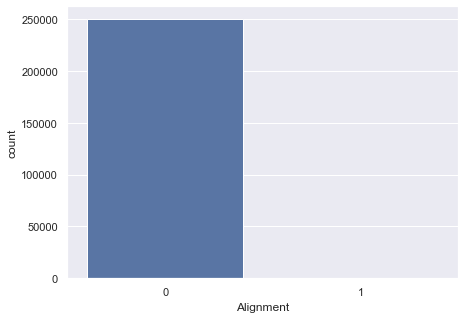

In [48]:
print(df['Alignment'].value_counts())
sns.set(rc = {'figure.figsize':(7,5)})
sns.countplot(x='Alignment',data=df)

#from the plot here we can see its a very highly skewed data. We might need to oversample

In [14]:
# Find missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
display(missing_value_df)

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.0000
entity_pair_names,entity_pair_names,0.0000
Structural_similarity,Structural_similarity,0.0000
Jaccardian_Similarity,Jaccardian_Similarity,0.0000
Sequence_Similarity,Sequence_Similarity,0.0000
Transformers_similarity,Transformers_similarity,0.0000
Spacy_similarity,Spacy_similarity,7.8416
Alignment,Alignment,0.0000


In [19]:
# drop all rows with any NaN and NaT values
df1 = df.dropna()
#drop unneccessary index column
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

C:\Users\Abel Teklearegay\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<Figure size 720x720 with 0 Axes>

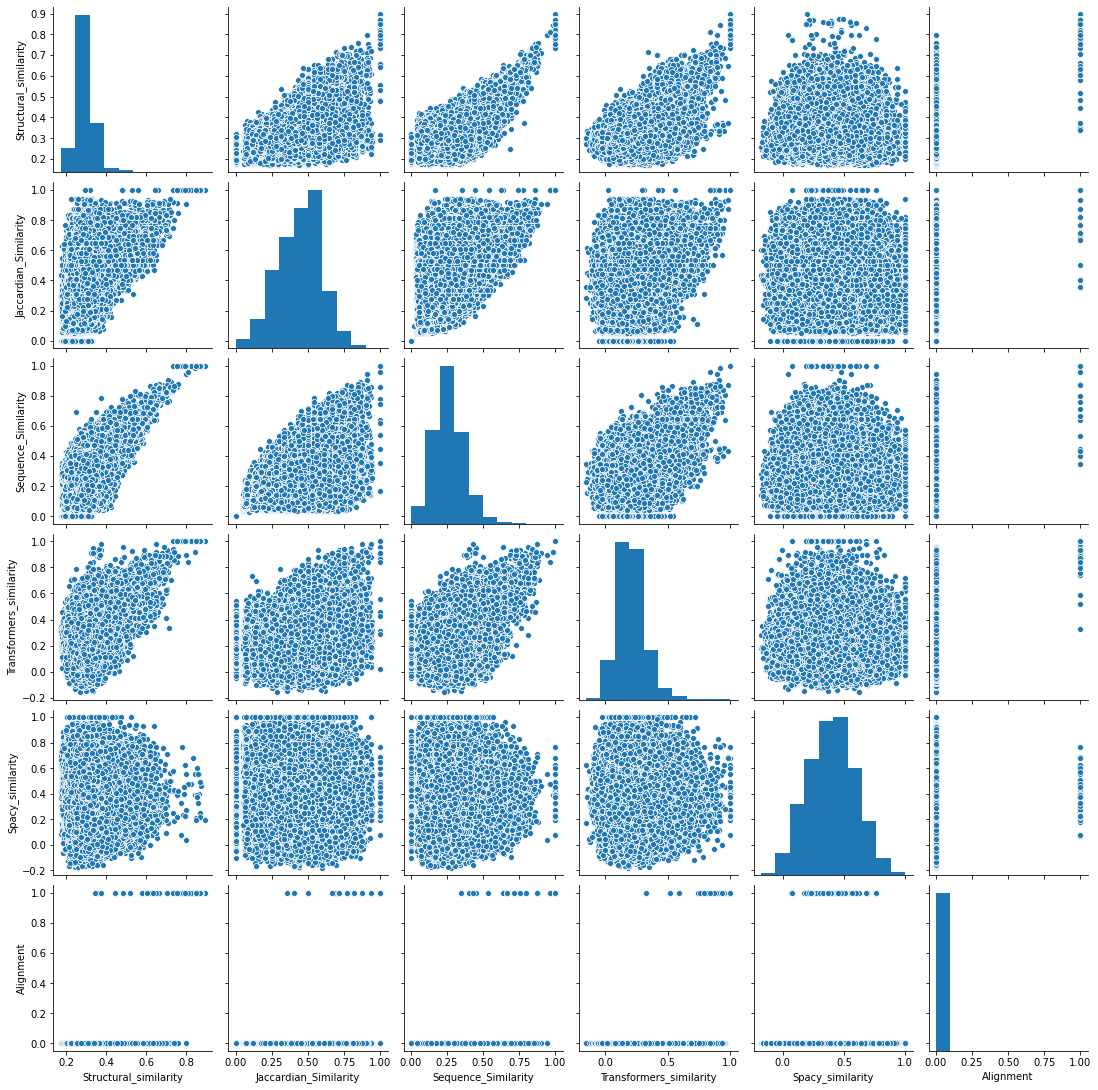

In [21]:
# Exploratory data analytics
plt.figure(figsize=(10, 10))
sns.pairplot(df1)
plt.show()

#diagonal histograms show the distribution of a single variable. They're usually skewed towards zero because there's not
# a lot of similarities. Right skewed.

#scatter plots on the upper and lower triangles show the relationship (or lack thereof) between two variables. We can see
#they're mostly positively correlated with eachother except for spacy.

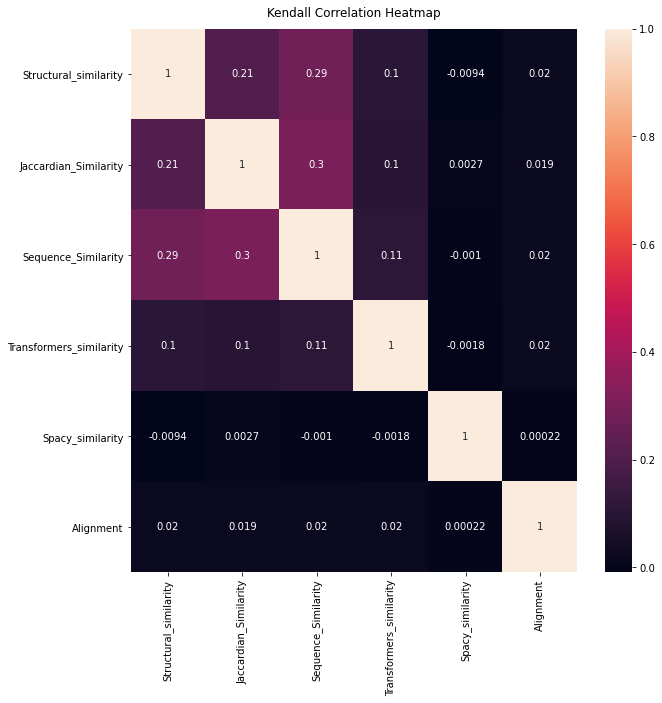

In [22]:
# Draw the correlation heatmaps using seaborn
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(df1.corr(method='kendall'), annot=True)
heatmap.set_title('Kendall Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

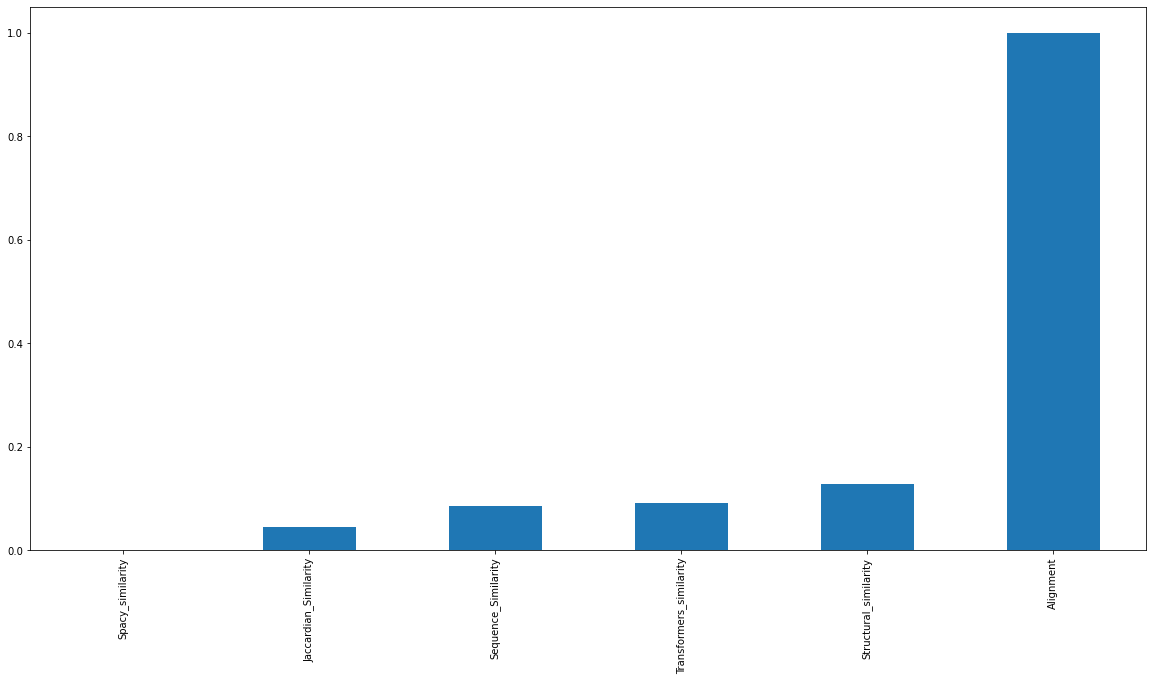

In [24]:
#plot the correlation graph

plt.figure(figsize=(20,10))
df1.corr()['Alignment'][:].sort_values().plot(kind='bar')

#we might need to get rid of spacy similarity

In [32]:
#filter out features with a correlation taregt less than 0.2

cor_target = abs(df1.corr()['Alignment'])
set_features = cor_target[cor_target > 0.01]
print(set_features)

Structural_similarity      0.127973
Jaccardian_Similarity      0.044707
Sequence_Similarity        0.085323
Transformers_similarity    0.091268
Alignment                  1.000000
Name: Alignment, dtype: float64


In [27]:
#filter out entity pair names
compDF = df1[['Structural_similarity', 'Jaccardian_Similarity', 'Sequence_Similarity','Transformers_similarity', 'Spacy_similarity','Alignment']]

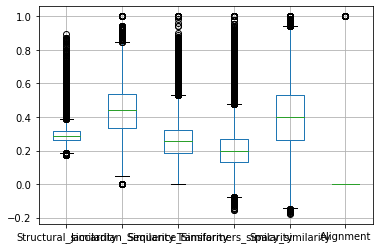

In [28]:
#after the above preprocessings we construct the bopxplot
#we can see from the figure none of the columns have much of a normal distribution and they're mostly skewed

compDF.boxplot(column=[i for i in compDF.columns])

In [149]:
y_label = 'Alignment'
compDFxtrain = compDF.loc[:, compDF.columns != y_label]

Index(['Structural_similarity', 'Jaccardian_Similarity', 'Sequence_Similarity',
       'Transformers_similarity', 'Spacy_similarity'],
      dtype='object')

# Functions for later uses

In [49]:
# Evaluation using cross validation
def eval_cv(classifier, metric):
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # evaluate model
    scores = cross_val_score(classifier, X, y, scoring=metric, cv=cv, n_jobs=-1)
    # report performance
    return mean(scores)

In [50]:
# Calculate the metrics
def calculate_metrics(df, method):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    df.loc[method] = [accuracy, precision, recall, f1, auc]

In [51]:
# Do the the cross validation of all metrics
def calculate_cv(df, classifier, method):
    accuracy = eval_cv(classifier, 'accuracy')
    precision = eval_cv(classifier, 'precision')
    recall = eval_cv(classifier, 'recall')
    f1 = eval_cv(classifier, 'f1')
    auc = eval_cv(classifier, 'roc_auc')
    df.loc[method] = [accuracy, precision, recall, f1, auc]

In [56]:
# included methods/models and metrics
methods = ['Logistic Regression','Linear Discriminant Analysis','KNN', 'Naive Bayes', 'Linear SVM', 'Decision Tree', 'AdaptiveBoosted Deecision tree','Random Forest', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC AUC']

# create model quality dataframe
quality_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_df)

# create model quality cross validation dataframe
quality_cv_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_cv_df)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,NaN,NaN,NaN,NaN,NaN
Linear Discriminant Analysis,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,NaN,NaN,NaN,NaN,NaN
Linear Discriminant Analysis,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


# Model Building

In [76]:
X = compDF.drop('Alignment',axis=1).values
y = compDF['Alignment'].values

#Split the dataset into 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


#robust scaling because its the least sensitive to outliers

rs_X = RobustScaler()
X_res = rs_X.fit_transform(X_train)

#Get the original X_test
X_test_orig = rs_X.inverse_transform(X_test)

#Do oversampling for the train set using SMOTE because its highly skewed
smn = SMOTEENN()


print("Counts before SMOTE")
print(Counter(y_train))

X_res,y_res = smn.fit_resample(X_res,y_train)
print("Counts after SMOTE")
print(Counter(y_res))

Counts before SMOTE
Counter({0: 184278, 1: 38})
Counts after SMOTE
Counter({1: 184278, 0: 183976})


In [144]:
X_train

array([[0.24744481, 0.55555556, 0.26086957, 0.09734642, 0.331     ],
       [0.27796787, 0.35714286, 0.20689655, 0.11028934, 0.194     ],
       [0.25612405, 0.6       , 0.11764706, 0.11157266, 0.076     ],
       ...,
       [0.29434988, 0.44444444, 0.16216216, 0.38328737, 0.165     ],
       [0.26583708, 0.35714286, 0.4       , 0.22606578, 0.629     ],
       [0.306852  , 0.61538462, 0.34482759, 0.04811526, 0.228     ]])

Logistic Regression

In [131]:
#Algorithm: LogisticRegression 

logmodel = LogisticRegression(C=3.0, max_iter=1000)
logmodel.fit(X_train,y_train)
y_pred = logmodel.predict(X_test)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


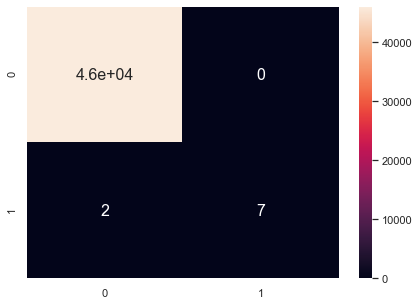

In [132]:
# Evaluate the model
method = 'Logistic Regression'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, logmodel, method)
display(quality_cv_df)

In [133]:
y_prob=logmodel.predict_proba(X_test)

print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       1.00      0.78      0.88         9

    accuracy                           1.00     46080
   macro avg       1.00      0.89      0.94     46080
weighted avg       1.00      1.00      1.00     46080



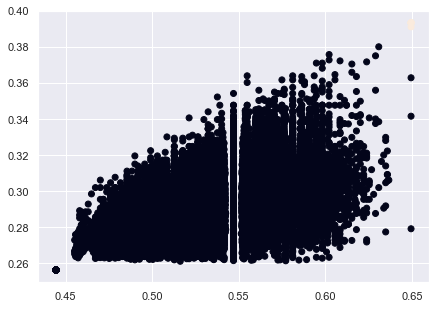

In [92]:
plt.scatter(X_test_orig[:,1], X_test_orig[:,2], c = y_pred)
plt.show()

Linear Discriminant Analysis

In [128]:
#Algorithm: Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit the model
ldamodel = LinearDiscriminantAnalysis()
ldamodel.fit(X_train,y_train)

# Run the model
y_pred = ldamodel.predict(X_test)


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


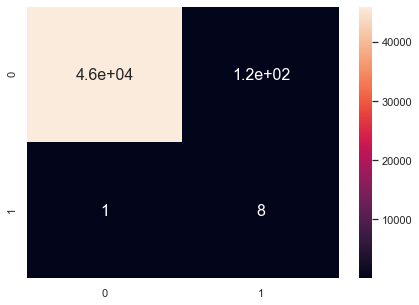

In [129]:
# Evaluate the model
method = 'Linear Discriminant Analysis'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, ldamodel, method)
display(quality_cv_df)

In [130]:
y_prob=ldamodel.predict_proba(X_test)

print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       0.06      0.89      0.11         9

    accuracy                           1.00     46080
   macro avg       0.53      0.94      0.56     46080
weighted avg       1.00      1.00      1.00     46080



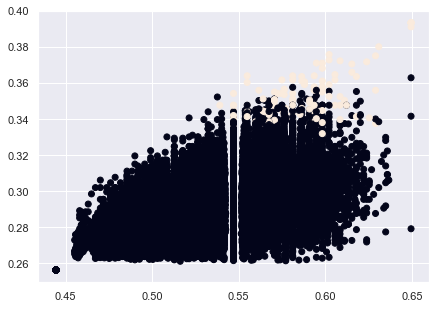

In [96]:
plt.scatter(X_test_orig[:,1], X_test_orig[:,2], c = y_pred)
plt.show()

KNN

In [125]:
#Algorithm: KNN
from sklearn.neighbors import KNeighborsClassifier


# Fit the model
knnmodel = KNeighborsClassifier()
knnmodel.fit(X_train, y_train)

# Run the model
y_pred = knnmodel.predict(X_test)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


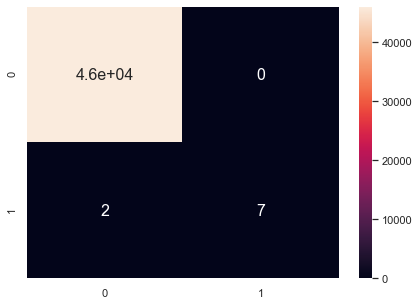

In [126]:
# Evaluate the model
method = 'KNN'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, knnmodel, method)
display(quality_cv_df)

In [127]:
y_prob=knnmodel.predict_proba(X_test)

print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       1.00      0.78      0.88         9

    accuracy                           1.00     46080
   macro avg       1.00      0.89      0.94     46080
weighted avg       1.00      1.00      1.00     46080



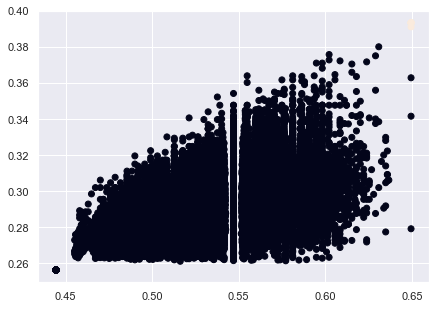

In [100]:
plt.scatter(X_test_orig[:,1], X_test_orig[:,2], c = y_pred)
plt.show()

Naive Bayes

In [115]:
# Algorithm: Naive Bayes
from sklearn.naive_bayes import BernoulliNB


# Fit the model
bayesmodel = BernoulliNB()
bayesmodel.fit(X_train, y_train)

# Run the model
y_pred = bayesmodel.predict(X_test)


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


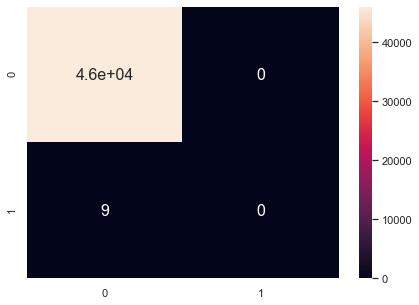

In [116]:
# Evaluate the model
method = 'Naive Bayes'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, bayesmodel, method)
display(quality_cv_df)

In [119]:
y_prob=bayesmodel.predict_proba(X_test)

print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       0.00      0.00      0.00         9

    accuracy                           1.00     46080
   macro avg       0.50      0.50      0.50     46080
weighted avg       1.00      1.00      1.00     46080



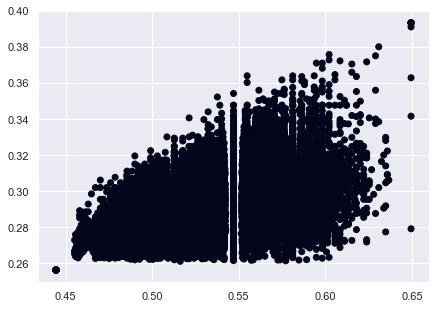

In [120]:
plt.scatter(X_test_orig[:,1], X_test_orig[:,2], c = y_pred)
plt.show()

Linear Support Vector Machines

In [121]:
# Algorithm: Support Vector Machines
from sklearn.svm import SVC

# Fit the model
svmmodel = SVC(probability=True, kernel='linear')
svmmodel.fit(X_train, y_train)

# Run the model
y_pred = svmmodel.predict(X_test)


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,NaN,NaN,NaN,NaN,NaN
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


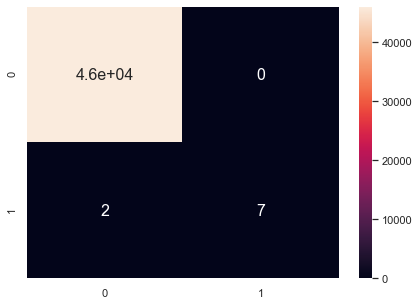

In [122]:
# Evaluate the model
method = 'Linear SVM'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, svmmodel, method)
display(quality_cv_df)

In [123]:
y_prob=svmmodel.predict_proba(X_test)

print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       1.00      0.78      0.88         9

    accuracy                           1.00     46080
   macro avg       1.00      0.89      0.94     46080
weighted avg       1.00      1.00      1.00     46080



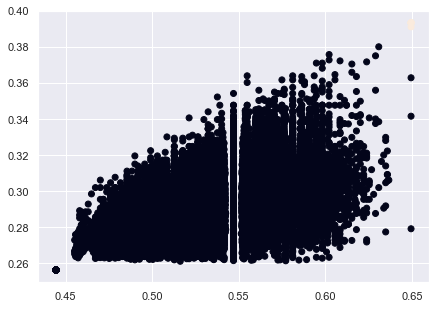

In [124]:
plt.scatter(X_test_orig[:,1], X_test_orig[:,2], c = y_pred)
plt.show()

Decision Trees

In [134]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

In [136]:
#ALgorithm: Decision trees without GridSearch
from sklearn.tree import DecisionTreeClassifier

# Fit the model
dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)

# Run the model
y_pred = dtmodel.predict(X_test)


In [137]:
print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       0.58      0.78      0.67         9

    accuracy                           1.00     46080
   macro avg       0.79      0.89      0.83     46080
weighted avg       1.00      1.00      1.00     46080



In [175]:
from sklearn.model_selection import GridSearchCV

# build the model
estimator = DecisionTreeClassifier()
parameters = {'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }

dtgsmodel = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
dtgsmodel.fit(X_train, y_train)

print("Best model parameters:", dtgsmodel.best_params_)

# Run the model
y_pred = dtgsmodel.predict(X_test)
y_prob = dtgsmodel.predict_proba(X_test)[:,1]

best_model = dtgsmodel.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model parameters: {'max_depth': 1, 'min_samples_leaf': 21, 'min_samples_split': 2}


In [176]:
feat_imps = get_feat_imp_df(dtgsmodel.best_estimator_.feature_importances_, index=compDFxtrain.columns)
# Use Feature importance to sub-sample features?

In [177]:
feat_imps

,importance
Transformers_similarity,1.0
Structural_similarity,0.0
Jaccardian_Similarity,0.0
Sequence_Similarity,0.0
Spacy_similarity,0.0


In [167]:
print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       0.75      0.67      0.71         9

    accuracy                           1.00     46080
   macro avg       0.87      0.83      0.85     46080
weighted avg       1.00      1.00      1.00     46080



,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,0.999891,0.75,0.666667,0.705882,0.833312
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,0.824,0.810568,0.840468,0.818268,0.830656
AdaptiveBoosted Deecision tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


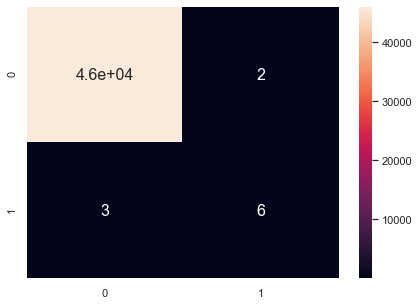

In [170]:
# Evaluate the model
method = 'Decision Tree'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, dtgsmodel, method)
display(quality_cv_df)

AdaptiveBoosted Deecision tree

In [171]:
#Algorithm: AdaptiveBoosted Deecision tree

from sklearn.ensemble import AdaBoostClassifier


# build the model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100, 200, 400], 
              'learning_rate': [0.001, 0.01, .1, 1]
             }
adboostmodel = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
adboostmodel.fit(X_train, y_train)

# Run the model
y_pred = adboostmodel.predict(X_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [172]:
print("Best model parameters:", adboostmodel.best_params_)

Best model parameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [181]:
feat_imps = get_feat_imp_df(adboostmodel.best_estimator_.feature_importances_, index=compDFxtrain.columns)
# Use Feature importance to sub-sample features?

In [182]:
feat_imps

,importance
Structural_similarity,0.38
Transformers_similarity,0.36
Jaccardian_Similarity,0.19
Sequence_Similarity,0.05
Spacy_similarity,0.02


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,0.999891,0.75,0.666667,0.705882,0.833312
AdaptiveBoosted Deecision tree,0.999935,1,0.666667,0.8,0.833333
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,0.824,0.810568,0.840468,0.818268,0.830656
AdaptiveBoosted Deecision tree,0.867667,0.869526,0.865913,0.866038,0.943072
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


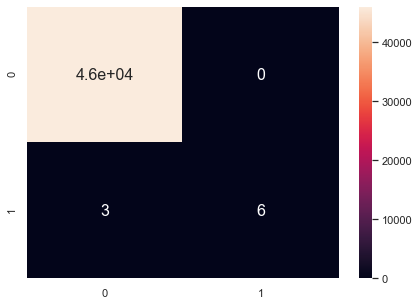

In [173]:
# Evaluate the model
method = 'AdaptiveBoosted Deecision tree'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, adboostmodel, method)
display(quality_cv_df)

In [174]:
print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       1.00      0.67      0.80         9

    accuracy                           1.00     46080
   macro avg       1.00      0.83      0.90     46080
weighted avg       1.00      1.00      1.00     46080



Random Forest

In [178]:
#Algorithm: Random Forest
from sklearn.ensemble import RandomForestClassifier

# build the model
estimator = RandomForestClassifier()
parameters = {'n_estimators': [10, 50, 100],
              'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }

rfmodel = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
rfmodel.fit(X_train, y_train)
print("Best model parameters:", rfmodel.best_params_)


# Run the model
y_pred = rfmodel.predict(X_test)


best_model = rfmodel.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best model parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [179]:
feat_imps = get_feat_imp_df(rfmodel.best_estimator_.feature_importances_, index=compDFxtrain.columns)
# Use Feature importance to sub-sample features?

In [180]:
feat_imps

,importance
Transformers_similarity,0.5
Structural_similarity,0.2
Sequence_Similarity,0.2
Jaccardian_Similarity,0.1
Spacy_similarity,0.0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,0.999891,0.75,0.666667,0.705882,0.833312
AdaptiveBoosted Deecision tree,0.999935,1,0.666667,0.8,0.833333
Random Forest,0.999935,1,0.666667,0.8,0.833333
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,0.824,0.810568,0.840468,0.818268,0.830656
AdaptiveBoosted Deecision tree,0.867667,0.869526,0.865913,0.866038,0.943072
Random Forest,0.918333,0.918948,0.928568,0.914392,0.975462
XGBoost,NaN,NaN,NaN,NaN,NaN


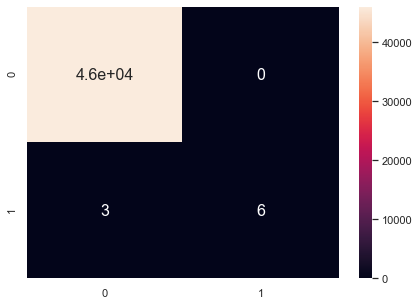

In [183]:
# Evaluate the model
method = 'Random Forest'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, rfmodel, method)
display(quality_cv_df)

In [184]:
print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       1.00      0.67      0.80         9

    accuracy                           1.00     46080
   macro avg       1.00      0.83      0.90     46080
weighted avg       1.00      1.00      1.00     46080



Gradient Boosting with XGboost

In [196]:
X_test

array([[0.27517996, 0.52941176, 0.33333333, 0.26406375, 0.608     ],
       [0.30219718, 0.5       , 0.17021277, 0.18348318, 0.316     ],
       [0.31858137, 0.28571429, 0.44444444, 0.21354894, 0.283     ],
       ...,
       [0.25281419, 0.2       , 0.13333333, 0.14796512, 0.431     ],
       [0.24454247, 0.38888889, 0.10526316, 0.17066687, 0.536     ],
       [0.32757748, 0.5       , 0.24242424, 0.09702639, 0.365     ]])

In [197]:
xtstMtrx = np.asmatrix(X_test)

In [199]:
from xgboost import XGBClassifier

# build the model
estimator = XGBClassifier()
parameters = {'max_depth': np.arange(3,6,2),
              'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000],
              'seed': [1430]
             }

xgbmodel = GridSearchCV(estimator, parameters, verbose=3, cv=5)
xgbmodel.fit(np.asmatrix(X_train), y_train)

print("Best model parameters:", xgbmodel.best_params_)


# Run the model
y_pred = xgbmodel.predict(np.asmatrix(X_test))



best_model = xgbmodel.best_estimator_


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[18:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8; total time=  14.7s
[18:41:17] WARNING: C:/Users/Administrator/wo

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8; total time=  18.9s
[18:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best model parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight

In [ ]:
#Best model parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 11, 
#'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1430, 'silent': 0, 'subsample': 0.8}

In [202]:
feat_imps = get_feat_imp_df(xgbmodel.best_estimator_.feature_importances_, index=compDFxtrain.columns)
# Use Feature importance to sub-sample features?

In [203]:
feat_imps

,importance
Jaccardian_Similarity,0.295909
Transformers_similarity,0.287711
Sequence_Similarity,0.259796
Structural_similarity,0.156584
Spacy_similarity,0.000000


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.999957,1,0.777778,0.875,0.888889
Linear Discriminant Analysis,0.997287,0.0606061,0.888889,0.113475,0.943099
KNN,0.999957,1,0.777778,0.875,0.888889
Naive Bayes,0.999805,0,0,0,0.5
Linear SVM,0.999957,1,0.777778,0.875,0.888889
Decision Tree,0.999891,0.75,0.666667,0.705882,0.833312
AdaptiveBoosted Deecision tree,0.999935,1,0.666667,0.8,0.833333
Random Forest,0.999935,1,0.666667,0.8,0.833333
XGBoost,0.999935,0.875,0.777778,0.823529,0.888878


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867,0.862608,0.87218,0.866001,0.943978
Linear Discriminant Analysis,0.865667,0.847831,0.890111,0.867168,0.943662
KNN,0.927667,0.924218,0.931179,0.92709,0.976234
Naive Bayes,0.795667,0.794029,0.794301,0.792098,0.872174
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Decision Tree,0.824,0.810568,0.840468,0.818268,0.830656
AdaptiveBoosted Deecision tree,0.867667,0.869526,0.865913,0.866038,0.943072
Random Forest,0.918333,0.918948,0.928568,0.914392,0.975462
XGBoost,0.911,0.910329,0.911832,0.910304,0.973328


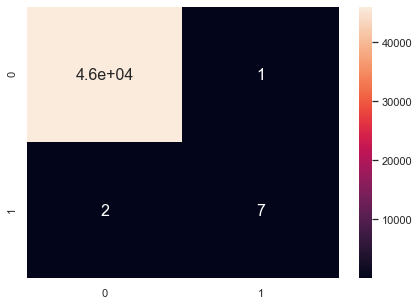

In [200]:
# Evaluate the model
method = 'XGBoost'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, xgbmodel, method)
display(quality_cv_df)

In [201]:
print(' Classification Report')
print('='*24)

cl_lin = classification_report(y_test,y_pred)
print(cl_lin)

 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46071
           1       0.88      0.78      0.82         9

    accuracy                           1.00     46080
   macro avg       0.94      0.89      0.91     46080
weighted avg       1.00      1.00      1.00     46080



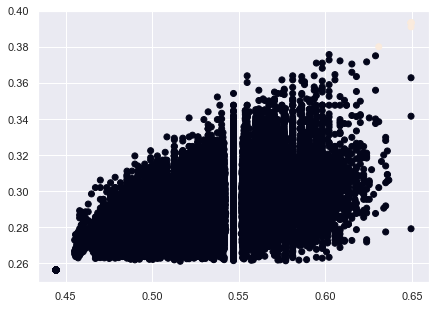

In [204]:
plt.scatter(X_test_orig[:,1], X_test_orig[:,2], c = y_pred)
plt.show()

In [205]:
X_test_orig[:,1]

array([0.55304173, 0.54700855, 0.5030525 , ..., 0.48547009, 0.52421652,
       0.54700855])

In [206]:
X_test_orig

array([[0.30171134, 0.55304173, 0.30201836, 0.23245131, 0.566768  ],
       [0.30309045, 0.54700855, 0.2796995 , 0.22127837, 0.487636  ],
       [0.30392679, 0.5030525 , 0.31722107, 0.22544715, 0.478693  ],
       ...,
       [0.30056967, 0.48547009, 0.2746535 , 0.21635359, 0.518801  ],
       [0.30014743, 0.52421652, 0.27081282, 0.21950132, 0.547256  ],
       [0.304386  , 0.54700855, 0.28957979, 0.20929066, 0.500915  ]])

In [207]:
X_test_orig[:,2]

array([0.30201836, 0.2796995 , 0.31722107, ..., 0.2746535 , 0.27081282,
       0.28957979])

In [208]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)